In [1]:
import random
import pandas as pd
import numpy as np
from math import log
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error as MSE


## 进行数据读入

In [6]:
buffer = pd.read_csv('pica2015.csv', header=0, encoding="utf-8", low_memory=False)
# print(buffer)
buffer.set_index('Unnamed: 0', inplace=True)
# buffer.head()
buffer.shape

(32130, 429)

In [5]:
# buffer.shape
buffer.columns
# buffer.index

Index(['CNTSCHID', 'Region', 'STRATUM', 'SUBNATIO', 'OECD', 'ADMINMODE',
       'Option_CPS', 'Option_FL', 'Option_ICTQ', 'Option_ECQ',
       ...
       'PV3SSES', 'PV4SSES', 'PV5SSES', 'PV6SSES', 'PV7SSES', 'PV8SSES',
       'PV9SSES', 'PV10SSES', 'SENWT', 'REPEAT'],
      dtype='object', length=429)

In [6]:
predict_buffer=buffer.loc[:,['ST001D01T','ST127Q01TA','ST127Q02TA','REPEAT']]
predict_buffer.head()
predict_buffer.shape

(32130, 4)

### 随机打乱索引

In [7]:
indices=[i for i in range(32130)]
random.shuffle(indices)


In [30]:
# 划分
validation_df=[]
for i in range(5):
    validation_df.append(predict_buffer.loc[indices[i*3213*2:(i+1)*3213*2],:])
print(validation_df[0].shape)

(6426, 4)


# Part 1

## 1 朴素贝叶斯

### 训练函数,验证函数

In [89]:
def bayes_train(bayes_training_set):
    y0_counts=len(bayes_training_set.loc[bayes_training_set['REPEAT']==0,'REPEAT'])
    y1_counts=len(bayes_training_set.loc[bayes_training_set['REPEAT']==1,'REPEAT'])
    dict1={}
    for xi in predict_buffer['ST001D01T'].unique():
        dict1[xi]={
            0:(len(bayes_training_set.loc[(bayes_training_set['ST001D01T']==xi)&(bayes_training_set['REPEAT']==0),'REPEAT'])+1)/(y0_counts+2),
            1:(len(bayes_training_set.loc[(bayes_training_set['ST001D01T']==xi)&(bayes_training_set['REPEAT']==1),'REPEAT'])+1)/(y1_counts+2)
        }

    dict2={}
    for xi in predict_buffer['ST127Q01TA'].unique():
        dict2[xi]={
            0:(len(bayes_training_set.loc[(bayes_training_set['ST127Q01TA']==xi)&(bayes_training_set['REPEAT']==0),'REPEAT'])+1)/(y0_counts+2),
            1:(len(bayes_training_set.loc[(bayes_training_set['ST127Q01TA']==xi)&(bayes_training_set['REPEAT']==1),'REPEAT'])+1)/(y1_counts+2)
        }

    dict3={}
    for xi in predict_buffer['ST127Q02TA'].unique():
        dict3[xi]={
            0:(len(bayes_training_set.loc[(bayes_training_set['ST127Q02TA']==xi)&(bayes_training_set['REPEAT']==0),'REPEAT'])+1)/(y0_counts+2),
            1:(len(bayes_training_set.loc[(bayes_training_set['ST127Q02TA']==xi)&(bayes_training_set['REPEAT']==1),'REPEAT'])+1)/(y1_counts+2)
        }

    dict_bayes={'ST001D01T':dict1, 'ST127Q01TA':dict2, 'ST127Q02TA':dict3}
    p_y0=y0_counts/(y0_counts+y1_counts)
    p_y1=y1_counts/(y0_counts+y1_counts)
    return dict_bayes,p_y0,p_y1

In [92]:
def bayes_validate(bayes_validation_set,dict_bayes, p_y0, p_y1):
    count=0
    for index in bayes_validation_set.index:
        row = bayes_validation_set.loc[index,:]
        value_y0 = dict_bayes['ST001D01T'][row['ST001D01T']][0] * dict_bayes['ST127Q01TA'][row['ST127Q01TA']][0] * dict_bayes['ST127Q02TA'][row['ST127Q02TA']][0] * p_y0
        value_y1= dict_bayes['ST001D01T'][row['ST001D01T']][1] * dict_bayes['ST127Q01TA'][row['ST127Q01TA']][1] * dict_bayes['ST127Q02TA'][row['ST127Q02TA']][1] * p_y1
        if value_y0>value_y1:
            prediction = 0
        elif value_y0<value_y1:
            prediction = 1
        else:
            input('equal?')
        if prediction==row['REPEAT']:
            count+=1
    print('accuracy:',count/(3213*2))
    return count/(3213*2)

### 交叉验证(k=5)

In [93]:
print('cross validating...')
ac_sum=0
for i in range(5):
    print('round {}:'.format(i+1))
    bayes_training_set=predict_buffer.loc[indices[:i*3213*2]+indices[(i+1)*3213*2:],:]
    bayes_validation_set=bayes_training_set=predict_buffer.loc[indices[i*3213*2:(i+1)*3213*2],:]
    dict_bayes, p_y0, p_y1 = bayes_train(bayes_training_set)
    ac_sum+=bayes_validate(bayes_validation_set, dict_bayes, p_y0, p_y1)
print('average accuracy:',ac_sum/5)

cross validating...
round 1:
accuracy: 0.9970432617491441
round 2:
accuracy: 0.9971988795518207
round 3:
accuracy: 0.9971988795518207
round 4:
accuracy: 0.9964207905384376
round 5:
accuracy: 0.997510115157174
average accuracy: 0.9970743853096794


## 2 决策树

### 实现

In [25]:
def get_disciminator(dataset):
    y0_count=len(dataset.loc[dataset['REPEAT']==0,'REPEAT'])
    y1_count=len(dataset.loc[dataset['REPEAT']==1,'REPEAT'])
    y0_rate=y0_count/(y0_count+y1_count)
    y1_rate=y1_count/(y0_count+y1_count)
    if y0_rate==0 or y1_rate==0:
        # print("???")
        return None

    entropy=-y0_rate*log(y0_rate)-y1_rate*log(y1_rate)
    best_gain=0
    discriminator=None
    for col in dataset.columns:
        if col=='REPEAT':
            continue
        gain=entropy
        for x in dataset.loc[:,col].unique().tolist():
            # print(x)
            count_0=len(dataset.loc[(dataset[col]==x)&(dataset['REPEAT']==0),'REPEAT'])
            count_1=len(dataset.loc[(dataset[col]==x)&(dataset['REPEAT']==1),'REPEAT'])
            rate0=count_0/(count_0+count_1)
            rate1=count_1/(count_0+count_1)
            # print(count_0,count_1)
            if count_0!=0 and count_1!=0:
                gain-=((count_0+count_1)/(y0_count+y1_count))*(-rate0*log(rate0)-rate1*log(rate1))
        # print(gain)
        if gain>best_gain:
            discriminator=col
            best_gain=gain
    return discriminator

def split(dataset,discriminator):
    subset={}
    for value in dataset.loc[:,discriminator].unique().tolist():
        subset[value]=dataset.loc[(dataset[discriminator]==value),:]
    return subset

In [51]:
class decision_tree(object):
    def __init__(self, dataset):
        self.Child_node={}
        self.d=get_disciminator(dataset)
        self.predict=-1
        self.label=int(len(dataset.loc[dataset['REPEAT']==0,'REPEAT']) < len(dataset.loc[dataset['REPEAT']==1,'REPEAT']))
        # print(self.d)
        if self.d!=None:
            subset=split(dataset,self.d)
            for set in subset.keys():
                # print(set)
                self.Child_node[set]=decision_tree(subset[set])
        else:
            self.predict=self.label

    def classify(self,x):
        if self.predict!=-1:
            return self.predict
        else:
            # print(x[self.d])
            # print(self.Child_node[x[self.d]])
            try:
                return self.Child_node[x[self.d]].classify(x)
            except:
                # print(self.d,self.Child_node.keys(),x[self.d])
                # input("???")
                return self.label
    
    def print_tree(self):
        print(self.d)
        for child in self.Child_node.values():
            child.print_tree()


### 测试

In [52]:
print('cross validating...')
ac_sum=0

for i in range(5):
    print('round {}:'.format(i+1))
    correct=0
    training_set=predict_buffer.loc[indices[:i*3213*2]+indices[(i+1)*3213*2:],:]
    validation_set=predict_buffer.loc[indices[i*3213*2:(i+1)*3213*2],:]
    my_tree=decision_tree(training_set)
    for index,row in validation_set.iterrows():
        if row['REPEAT']==my_tree.classify(row):
            correct+=1
    print('accuracy:',correct/(3213*2))
    ac_sum+=correct/(3213*2)
print('average accuracy:',ac_sum/5)

cross validating...
round 1:
accuracy: 0.9998443821973234
round 2:
accuracy: 1.0
round 3:
accuracy: 0.9998443821973234
round 4:
accuracy: 0.9998443821973234
round 5:
accuracy: 1.0
average accuracy: 0.999906629318394


# Part 2

#### 导入训练集标签

In [2]:
labels = pd.read_csv('label_train.csv', header=0, encoding="utf-8", low_memory=False)
# labels.set_index('Unnamed: 0', inplace=True)
labels.set_index('Unnamed: 0', inplace=True)
labels

,index,MATH
Unnamed: 0,,
6426,6426,520.378
6427,6427,563.734
6428,6428,597.299
6429,6429,421.818
6430,6430,511.234
...,...,...
32125,32125,396.169
32126,32126,398.557
32127,32127,396.373


#### 读入数据, 删去取值唯一属性和object类属性

In [3]:
df = pd.read_csv('pica2015.csv', header=0, encoding="utf-8", low_memory=False)
df.set_index('Unnamed: 0', inplace=True)
one_value_col = []
for col in list(df.columns):
    if len(df[col].unique()) == 1:
        one_value_col.append(col)
print(one_value_col)
df = df.drop(one_value_col, axis=1)
datatype = df.dtypes
datatype = datatype[datatype=='object']
df = df.drop(list(datatype.index), axis=1)
# df.shape
# df.head()
to_predict=df.loc[0:6426,:]
df = df.loc[6426:,:]
df

['OECD', 'ADMINMODE', 'Option_CPS', 'Option_FL', 'Option_ICTQ', 'Option_ECQ', 'Option_PQ', 'Option_TQ', 'Option_UH', 'Option_Read', 'Option_Math', 'ST003D03T', 'ST006Q04TA', 'ST008Q04TA', 'ST124Q01TA', 'ST127Q03TA']


,CNTSCHID,Region,SUBNATIO,LANGTEST_QQQ,LANGTEST_COG,CBASCI,BOOKID,ST001D01T,ST003D02T,ST004D01T,...,PV3SSES,PV4SSES,PV5SSES,PV6SSES,PV7SSES,PV8SSES,PV9SSES,PV10SSES,SENWT,REPEAT
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
6426,97100196,72404,7240400,160,160,6,94,10,7,2,...,411.089,491.040,523.839,531.440,499.505,488.832,487.122,489.874,0.05695,0
6427,97100196,72404,7240400,160,160,1,50,10,7,2,...,562.589,528.294,601.008,551.440,529.370,587.628,618.553,547.610,0.05695,0
6428,97100196,72404,7240400,160,160,2,39,10,7,2,...,535.619,505.339,427.786,450.275,503.253,517.877,576.331,488.961,0.05695,0
6429,97100196,72404,7240400,160,160,3,51,10,7,2,...,377.807,390.791,397.509,418.882,374.070,413.413,403.846,403.550,0.05695,0
6430,97100196,72404,7240400,160,160,4,95,10,7,2,...,499.929,484.723,508.225,531.021,498.783,485.738,489.025,554.735,0.05695,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32125,97100980,72416,7241600,156,156,7,51,9,1,2,...,333.743,443.126,415.404,407.680,355.131,380.074,354.619,339.136,0.03523,1
32126,97100980,72416,7241600,156,156,1,95,9,10,2,...,254.325,199.116,360.027,319.380,272.180,356.742,311.945,353.375,0.03523,1
32127,97100980,72416,7241600,156,156,3,37,9,7,2,...,345.183,335.601,397.349,327.727,318.283,343.219,382.890,317.025,0.03523,1


#### 相关性分析

In [6]:
df1 = pd.concat([df, labels.loc[:,'MATH']], axis=1)
corr=df1.corr()

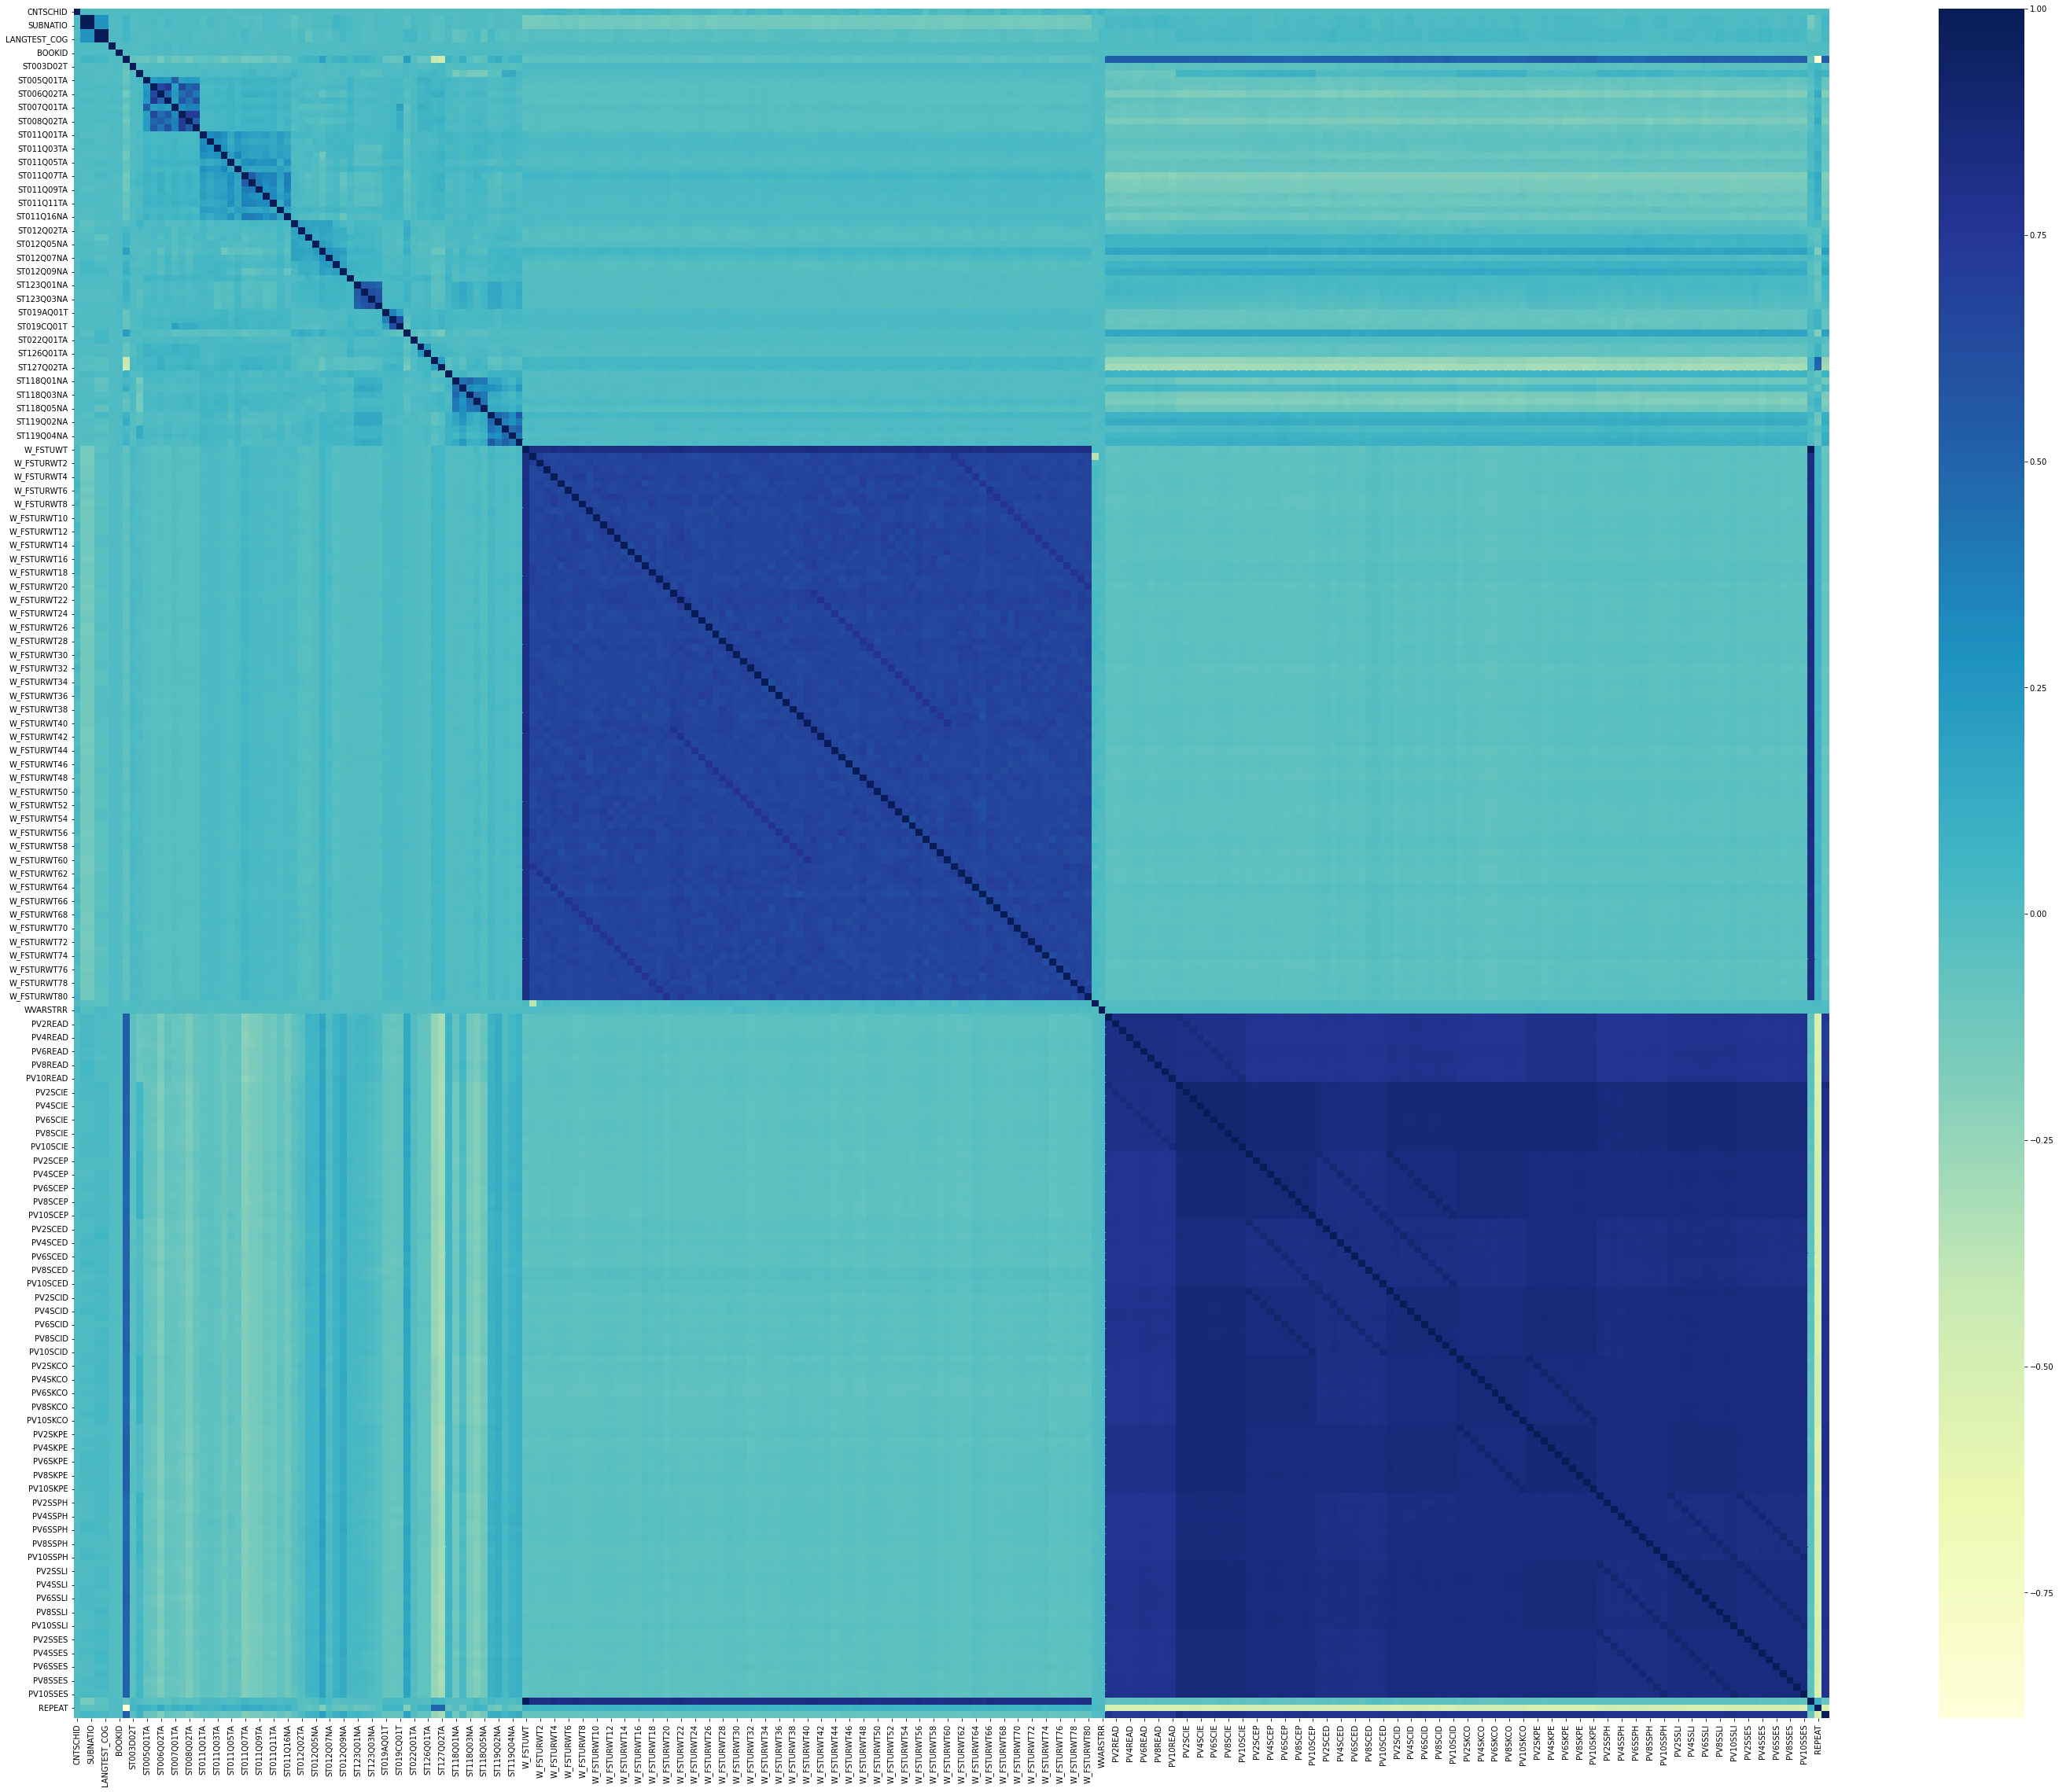

In [5]:
# plt.figure(figsize=(20, 15))
plt.figure(figsize=(50, 40))
sns.heatmap(corr,linewidths=0,linecolor='black',cmap='YlGnBu')
# plt.show()

[]

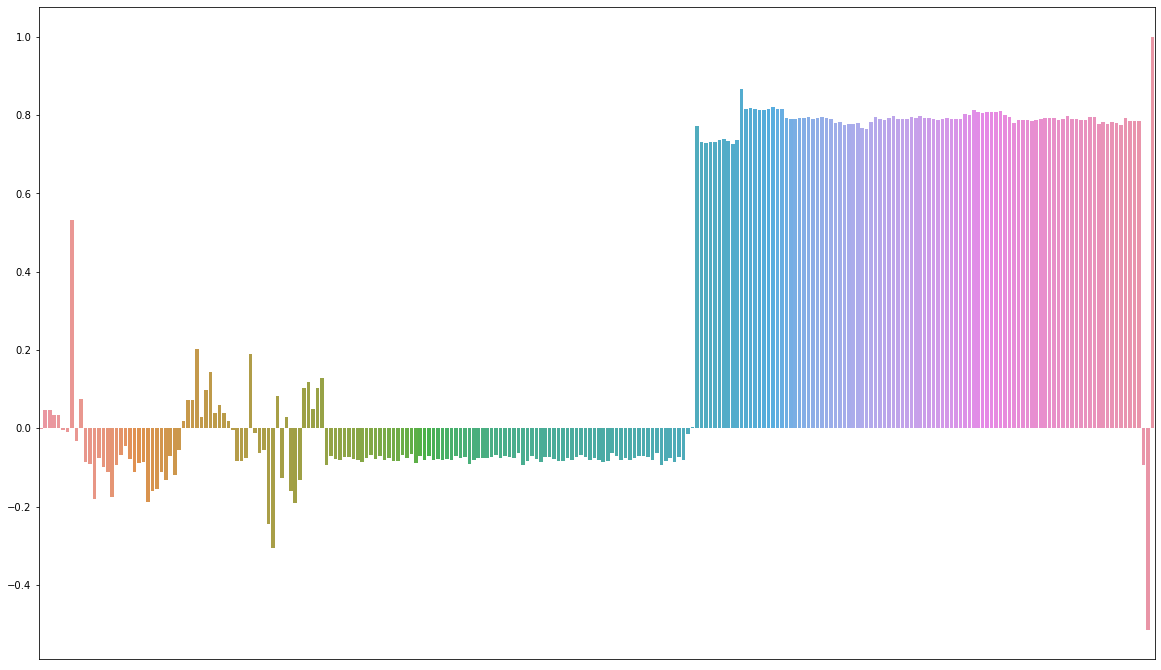

In [6]:
plt.figure(figsize=(20, 12))
sns.barplot(x=corr.columns.to_list(),y=corr.loc['MATH',:].to_list()).set_xticks(ticks=[])

In [7]:
corr_math=corr['MATH']
indices1=corr_math[abs(corr_math)>0.4].index.to_list()
indices1.remove('MATH')
print(indices1)

['ST001D01T', 'PV1READ', 'PV2READ', 'PV3READ', 'PV4READ', 'PV5READ', 'PV6READ', 'PV7READ', 'PV8READ', 'PV9READ', 'PV10READ', 'PV1SCIE', 'PV2SCIE', 'PV3SCIE', 'PV4SCIE', 'PV5SCIE', 'PV6SCIE', 'PV7SCIE', 'PV8SCIE', 'PV9SCIE', 'PV10SCIE', 'PV1SCEP', 'PV2SCEP', 'PV3SCEP', 'PV4SCEP', 'PV5SCEP', 'PV6SCEP', 'PV7SCEP', 'PV8SCEP', 'PV9SCEP', 'PV10SCEP', 'PV1SCED', 'PV2SCED', 'PV3SCED', 'PV4SCED', 'PV5SCED', 'PV6SCED', 'PV7SCED', 'PV8SCED', 'PV9SCED', 'PV10SCED', 'PV1SCID', 'PV2SCID', 'PV3SCID', 'PV4SCID', 'PV5SCID', 'PV6SCID', 'PV7SCID', 'PV8SCID', 'PV9SCID', 'PV10SCID', 'PV1SKCO', 'PV2SKCO', 'PV3SKCO', 'PV4SKCO', 'PV5SKCO', 'PV6SKCO', 'PV7SKCO', 'PV8SKCO', 'PV9SKCO', 'PV10SKCO', 'PV1SKPE', 'PV2SKPE', 'PV3SKPE', 'PV4SKPE', 'PV5SKPE', 'PV6SKPE', 'PV7SKPE', 'PV8SKPE', 'PV9SKPE', 'PV10SKPE', 'PV1SSPH', 'PV2SSPH', 'PV3SSPH', 'PV4SSPH', 'PV5SSPH', 'PV6SSPH', 'PV7SSPH', 'PV8SSPH', 'PV9SSPH', 'PV10SSPH', 'PV1SSLI', 'PV2SSLI', 'PV3SSLI', 'PV4SSLI', 'PV5SSLI', 'PV6SSLI', 'PV7SSLI', 'PV8SSLI', 'PV9SSLI',

#### 回归预测

In [17]:
reg1=LR()
cv_hist=cross_val_score(reg1,df,labels.loc[:,'MATH'],cv=5,scoring="neg_mean_squared_error")
print(cv_hist)
print(np.mean(cv_hist))

[-1408.30789201 -1424.36782319 -1463.4243469  -1474.48966103
 -1483.62524664]
-1450.8429939551947


In [11]:
'预测'
reg1=LR()
reg1.fit(df,labels.loc[:,'MATH'])
y_pred = reg1.predict(to_predict)
# print(y_pred)
y_pred=list(zip([i for i in range(6426)], y_pred))
pd.DataFrame(data=y_pred, columns=['index', 'MATH']).to_csv('方子元_PB19051166_exp4.csv')

In [11]:
rr_reg=Ridge(alpha=10)
cv_hist=cross_val_score(rr_reg,df,labels.loc[:,'MATH'],cv=5,scoring="neg_mean_squared_error")
print(cv_hist)
print(np.mean(cv_hist))

[-1408.14103587 -1424.8875124  -1463.65485618 -1474.4002651
 -1480.49244356]
-1450.3152226222019


In [14]:
lasso_reg = Lasso(alpha=10,max_iter=10000)
cv_hist=cross_val_score(lasso_reg,df,labels.loc[:,'MATH'],cv=5,scoring="neg_mean_squared_error")
print(cv_hist)
print(np.mean(cv_hist))

[-1479.72675767 -1521.61686    -1526.88738505 -1543.87794956
 -1532.6728781 ]
-1520.9563660753274


In [9]:
'只使用相关系数大于0.4的特征'
reg2=LR()
cv_hist=cross_val_score(reg2,df.loc[:,indices1],labels.loc[:,'MATH'],cv=5,scoring="neg_mean_squared_error")
print(cv_hist)
print(np.mean(cv_hist))

[-1494.0930678  -1488.02805154 -1515.3211616  -1522.10296784
 -1513.16573585]
-1506.5421969254894


#### MLP

In [12]:
import torch
import torch.nn as nn
import torch.utils.data as Data

In [29]:
df.to_numpy().shape
# labels.loc[:,['MATH']].to_numpy().shape

,CNTSCHID,Region,SUBNATIO,LANGTEST_QQQ,LANGTEST_COG,CBASCI,BOOKID,ST001D01T,ST003D02T,ST004D01T,...,PV3SSES,PV4SSES,PV5SSES,PV6SSES,PV7SSES,PV8SSES,PV9SSES,PV10SSES,SENWT,REPEAT
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
6426,97100196,72404,7240400,160,160,6,94,10,7,2,...,411.089,491.040,523.839,531.440,499.505,488.832,487.122,489.874,0.05695,0
6427,97100196,72404,7240400,160,160,1,50,10,7,2,...,562.589,528.294,601.008,551.440,529.370,587.628,618.553,547.610,0.05695,0
6428,97100196,72404,7240400,160,160,2,39,10,7,2,...,535.619,505.339,427.786,450.275,503.253,517.877,576.331,488.961,0.05695,0
6429,97100196,72404,7240400,160,160,3,51,10,7,2,...,377.807,390.791,397.509,418.882,374.070,413.413,403.846,403.550,0.05695,0
6430,97100196,72404,7240400,160,160,4,95,10,7,2,...,499.929,484.723,508.225,531.021,498.783,485.738,489.025,554.735,0.05695,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32125,97100980,72416,7241600,156,156,7,51,9,1,2,...,333.743,443.126,415.404,407.680,355.131,380.074,354.619,339.136,0.03523,1
32126,97100980,72416,7241600,156,156,1,95,9,10,2,...,254.325,199.116,360.027,319.380,272.180,356.742,311.945,353.375,0.03523,1
32127,97100980,72416,7241600,156,156,3,37,9,7,2,...,345.183,335.601,397.349,327.727,318.283,343.219,382.890,317.025,0.03523,1


In [48]:
class Net(nn.Module):
    def __init__(self, input_size, n_output):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size,100)
        self.activate = nn.ReLU()
        # self.activate = nn.Tanh()
        # self.activate = nn.Sigmoid()
        self.fc2 = nn.Linear(100,10)
        self.fc3 = nn.Linear(10,n_output)
        # self.fc4 = nn.Linear(hidden_size,hidden_size)
        # self.fc5 = nn.Linear(hidden_size,hidden_size)
        # self.af2 = nn.Tanh()
        # self.fc0 = nn.Linear(hidden_size,n_output)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.activate(out)
        out = self.fc2(out)
        out = self.activate(out)
        out = self.fc3(out)
        # out = self.activate(out)
        # out = self.fc4(out)
        # out = self.activate(out)
        # out = self.fc5(out)
        # out = self.activate(out)
        # out = self.fc0(out)
        return out

In [33]:
indices_2=[i for i in range(6426,32130)]
random.shuffle(indices_2)

In [34]:
# df.to_numpy().shape
# labels.loc[:,['MATH']].to_numpy().shape
# df
df2 = (df-df.mean())/df.std()  
data = torch.Tensor(df2.loc[indices_2[5140:25704],:].to_numpy())
label = torch.Tensor(labels.loc[indices_2[5140:25704],['MATH']].to_numpy())
training_set = Data.TensorDataset(data, label)
loader = Data.DataLoader(
        dataset=training_set,  # torch TensorDataset format
        batch_size=32,  # mini batch size
        shuffle=True,  # 要不要打乱数据 (打乱比较好)
        # num_workers=2,  # 多线程来读数据
    )


In [49]:
model = Net(249, 1).cuda()
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_func = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

Net(
  (fc1): Linear(in_features=249, out_features=100, bias=True)
  (activate): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)


In [39]:
def validate():
    data_validate = torch.Tensor(df2.loc[indices_2[0:5140],:].to_numpy())
    label_validate = torch.Tensor(labels.loc[indices_2[0:5140],['MATH']].to_numpy())
    validation_set = Data.TensorDataset(data_validate, label_validate)
    loader_validate = Data.DataLoader(
            dataset=validation_set,  # torch TensorDataset format
            batch_size=32,  # mini batch size
            shuffle=True,  # 要不要打乱数据 (打乱比较好)
            # num_workers=2,  # 多线程来读数据
        )

    validate_loss=[]
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(loader_validate):
            # print(batch_x)
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            prediction = model(batch_x)
            # print(prediction)
            loss = loss_func(prediction,batch_y)
            validate_loss.append(loss.item())
    
    print(np.mean(validate_loss))

In [50]:
loss_his = {}
for epoch in range(30):
    print('epoch:{}'.format(epoch+1))
    loss_his[epoch+1]=[]
    for step, (batch_x, batch_y) in enumerate(loader):
        # print(batch_x)
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        prediction = model(batch_x)
        # print(prediction)
        loss = loss_func(prediction,batch_y)
        # print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_his[epoch+1].append(loss.item())
    scheduler.step()
    print('training loss:{}'.format(np.mean(loss_his[epoch+1])))
    validate()

epoch:1
training loss:32259.217203902605
9360.343925902562
epoch:2
training loss:4286.48502654792
2466.560283021157
epoch:3
training loss:2106.1307757482928
1923.1174160975106
epoch:4
training loss:1751.7555203118925
1773.780249554178
epoch:5
training loss:1671.2956099680757
2312.216013653678
epoch:6
training loss:1590.9002370404232
1748.0933845472632
epoch:7
training loss:1520.3991855366235
1715.7416605505143
epoch:8
training loss:1477.7010587274008
1606.7051012501213
epoch:9
training loss:1443.3433205706892
1675.536591903023
epoch:10
training loss:1418.108191696333
1671.487693265358
epoch:11
training loss:1384.3103036835998
1627.9195969860007
epoch:12
training loss:1375.0045876035795
1634.645704186481
epoch:13
training loss:1343.1859710835743
1593.280257136185
epoch:14
training loss:1326.3676872668705
1656.6996315902804
epoch:15
training loss:1325.4808179698132
1601.4902764551389
epoch:16
training loss:1294.2239978843677
1551.702501000825
epoch:17
training loss:1284.7156140459456
152